<font color='blue' size = 6 > <strong> LIBRAIRIES </strong>  </font>\
\
At the beginning of all notebooks, it is necessary to load the packages that will be used to run the code. Note that some librairies might be called within other "bits" of code hidden in other files.

In [169]:
import sys

#Ensure latest version of fsspec is used to allow simpletemplate=True of reference file system
sys.path.insert(0,'/home/jovyan/filesystem_spec')

import xarray as xr
import numpy as np
import pandas as pd
import cmocean
from scipy import stats
import matplotlib.pyplot as plt
import cmocean
import cartopy
import cartopy.crs as ccrs
import datetime
import fsspec
import xarray as xr
import os, glob
import hvplot.xarray 
import panel as pn
from time import strptime

%run SST_fun.ipynb

<font color='blue' size = 6 > <strong> CLUSTER FIRING </strong>  </font>\
\
Let's now create a cluster to allow for faster loading time

In [2]:
gateway_cluster = True
from dask.distributed import Client, LocalCluster
from dask_gateway import Gateway

# Dask gateway
if gateway_cluster:
    gateway = Gateway()
    clusters = gateway.list_clusters()
    if not clusters:
        print('Creating new cluster. Please wait for this to finish.')
        options = gateway.cluster_options()
        options.worker_cores = 1
        options.worker_memory = 1.0
        cluster = gateway.new_cluster(cluster_options=options)
    else:
        print(f'An existing cluster was found. Connected to cluster \033[1m{clusters[0].name}\033[0m')
        cluster=gateway.connect(clusters[0].name)
#     cluster.adapt(minimum=1, maximum=30)
    cluster.scale(180)
    client = cluster.get_client()
    client.wait_for_workers(n_workers=180)

# Local cluster
else:
    cluster = LocalCluster()
    client = Client(cluster)

display(cluster)
display(client)

Creating new cluster. Please wait for this to finish.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.e79b8f5656ce413a805a0276a3f3babb/status,


<font color='blue' size = 6 > <strong> DATA DESCRIPTION </strong>  </font>\
\
After we load the necessary libraies, the user needs to indicate the dataset and region of interest.

For this workshop, users have a choice between satellite SST products hosted by IMOS including SST and chlorophyll or data from the BlueLink ReAnalysis (BRAN) model created by CSIRO hosted on the National Computing Infrastructure servers in Canberra 

In [3]:
## This creates a random dataset for testing use only ##
lat = np.float32(np.arange(-35,-30,.1))
lon = np.float32(np.arange(100,105,.1))
time = pd.date_range("1990-01-01",periods = 365*30)
sst = abs(np.random.randn(lon.size,lat.size,time.size))*20+15+293.7
flag = (np.random.randn(lon.size,lat.size,time.size)*10).round()
data = xr.Dataset(data_vars=dict(sea_surface_temperature=(["lon","lat","time"],sst),flag=(["lon","lat","time"],flag)),coords=dict(lon=("lon",lon),lat=("lat",lat),time = ("time",time)))
data['sea_surface_temperature'] = data.sea_surface_temperature-293.7 #Kelvin to Celsius conversion


In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Interactive panel to list details of different available products, including variables, coordinates, time step and text description.
@interact
def show_timeseries(coord = ['lon','lat','time']):
    return data[coord]
  

interactive(children=(Dropdown(description='coord', options=('lon', 'lat', 'time'), value='lon'), Output()), _…

<font color='blue' size = 6 > <strong> LOAD THE DATA </strong>  </font>\
\
Once the user was able to have a quick look at the available products, we need to indicate the product name and region of interest so that we can load the data

In [3]:
%%time
data = open_stack('imos-data-pixeldrill-refs/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/agg_monthly/',
                extension='json',
                open_func=open_and_crop,
                storage_options=dict(key=key,secret=secret),
                open_kwargs=dict(load=True,
                                 simple_templates=True,
                                 cropto=dict(lat=slice(-32.0,-32.5),lon=slice(115.4,115.9))))

data['sea_surface_temperature']-= 273.15 # Kelvin to Celsuis conversion


CPU times: user 1.24 s, sys: 165 ms, total: 1.41 s
Wall time: 14.6 s


In [174]:
#from scipy import stats
#import matplotlib.pyplot as plt
%matplotlib inline 
@interact
def plot_ts(longitude=(data.lon.values.min(),data.lon.values.max(),np.abs(np.diff(data.lon).mean())),latitude=(data.lat.values.min(),data.lat.values.max(),np.abs(np.diff(data.lat).mean())),time_step = ['month','year'],variable = list(data.keys())):

    ylab = variable
    freq = {'month':'M','year':'Y'}
    if time_step == 'day':
        test = data[variable]
    else:
        test = time_average(data,freq[time_step],var=ylab,ignore_inc = False)
      
    fig = plt.figure(figsize=(30,8))
    plt.subplot(1,2,1)
    coef,fit,hci,lci = lin_trend(test.sel(lon=longitude,lat=latitude),'time')
    fit = fit.assign(hci = hci['linear_fit'], lci = lci['linear_fit'])

    test.sel(lon=longitude,lat=latitude).plot() 
    fit['linear_fit'].plot(color='red') 
    xl = test.coords['time'].values
    plt.xlim(xl.min(),xl.max())
    
    plt.fill_between(lci['time'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.5,color='grey')
    plt.gca().set_ylabel(ylab,fontsize = 20)
    plt.gca().set_xlabel(plt.gca().get_xlabel(),fontsize = 20)
    plt.gca().tick_params(labelsize = 15)
    plt.gca().set_title(time_step+'ly mean - lon:'+str(round(longitude,5))+ ' ; lat:'+str(round(latitude,5)),fontsize = 20);
    
    plt.subplot(1,4,3,projection=ccrs.PlateCarree())
    ax,gl,axproj = map(data[ylab].mean(dim='time'),[data.lon.min(),data.lon.max()],[data.lat.min(),data.lat.max()],cmap = cmocean.cm.thermal,add_colorbar = True,title='Time-Mean',cbar_kwargs={'shrink':0.6})
    ax.set_title(ax.get_title(),fontsize = 20)
    gl.xlabel_style = {'size':12}
    gl.ylabel_style = {'size':12}
    plt.scatter(longitude,latitude,s=55,marker="o",edgecolor = 'black',color = 'white',zorder=3)
    fig1 = plt.gcf()
    plt.show()
    
    def save_fig(button):
        fig1.savefig("ts_location_lon {:.2f} _lat {:.2f}.jpg".format(longitude,latitude))
    save_but = widgets.Button(description='Save Figure')
    display(save_but)
    save_but.on_click(save_fig)
    
    return
   

interactive(children=(FloatSlider(value=115.41000366210938, description='longitude', max=115.88999938964844, m…

In [171]:
# Interactive Map

import calendar
day_list = np.arange(0,31,1)
month_list = [calendar.month_abbr[x] for x in np.arange(0,12,1)]
year_list = np.append(0,np.unique(data.time.dt.year))

print("Specifying '0' for Day/Month/Year will perform a monthly/yearly/time average")
#box_layout = Layout(display = 'flex',flex_flow = 'row')
@interact
def plot_ts(Day = day_list, Month = month_list, Year = year_list,variable = list(data.keys())):
    ylab = variable
    day_sel = np.arange(1,32,1) if Day == 0 else Day
    mn_sel = np.arange(1,13,1) if Month == '' else strptime(Month,'%b').tm_mon
    yr_sel = np.arange(data.time.dt.year.min(),data.time.dt.year.max()+1,1) if Year == 0 else Year
    
    date_str = str(Year) + '-' + str(Month) + '-' + str(Day)
    
    title_yr = f"{Year:04}"
    title_mn =  Month
    title_day = f"{Day:02}"
    if Year == 0:
        title_yr = 'All'
    if Month == '':
        title_mn = 'All'
    if Day == 0:
        title_day = 'All'
    if (Year == 0) & (Month == 0) & (Day == 0):
        title = 'Time-Mean'
    else:
        title = 'Year: {}   Month: {}   Day: {}'.format(title_yr,title_mn,title_day)

    da = data[ylab][(data.time.dt.year.isin(yr_sel)) & (data.time.dt.month.isin(mn_sel)) & data.time.dt.day.isin(day_sel)].mean(dim = 'time')
    fig1 = plt.figure(figsize=(20,12))
    ax,gl,axpl = map(da,[data.lon.min(),data.lon.max()],[data.lat.min(),data.lat.max()],cmap = cmocean.cm.thermal,add_colorbar = False,title=title)
    cb = create_cb(fig1,ax,axpl,variable,size = "4%", pad = 0.5,labelpad = 20,fontsize=20)
    cb.ax.tick_params(labelsize = 15)
    ax.set_title(ax.get_title(),fontsize = 25)
    gl.xlabel_style = {'size':15}
    gl.ylabel_style = {'size':15}
    
    def save_fig(button):
        fig1.savefig("map_yr{}_mn{}_dy{}.jpg".format(title_yr,title_mn,title_day))
    save_but = widgets.Button(description='Save Figure')
    display(save_but)
    save_but.on_click(save_fig)


Specifying '0' for Day/Month/Year will perform a monthly/yearly/time average


interactive(children=(Dropdown(description='Day', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

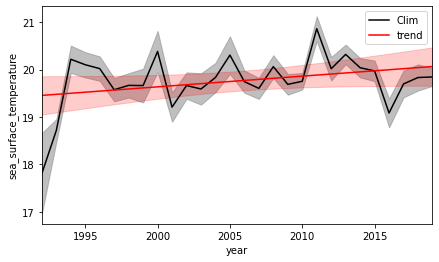

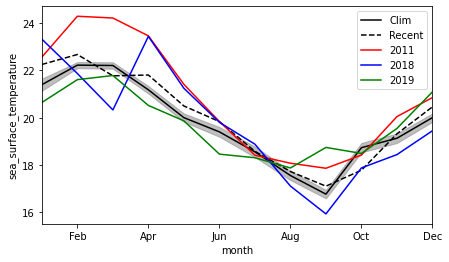

In [8]:


data_bavg = data.stack(space=['lon','lat']).mean(dim='space')

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2019-12-31'],'year')
ylab = ax.get_ylabel()

coef,fit,hci,lci = lin_trend(clim,'year')
fit['linear_fit'].plot(ax=ax,color='red',label = 'trend')
plt.fill_between(lci['year'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.2,color='red')
ax.set_ylabel(ylab)
plt.legend()

clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],['1990-01-01','2010-12-31'],'month',time_recent = ['2011-01-01', None],ind_yr = [2011,2018 ,2019])


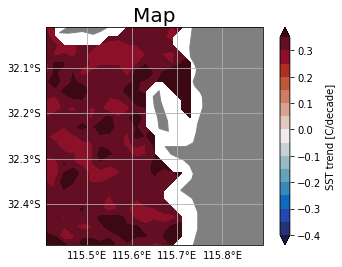

In [9]:
#Map linear trends
clim = make_clim(data['sea_surface_temperature'],time_res = 'year')
coef,fit,hci,lci= lin_trend(clim[0],'year',deg=1)
coef = coef.rename({'polyfit_coefficients':'SST trend [C/decade]'})

ax,gl = map((coef.isel(degree=0)['SST trend [C/decade]']*10),[coef.lon.min(),coef.lon.max()],[coef.lat.min(),coef.lat.max()],cmap = cmocean.cm.balance,vmin = -0.4,vmax = 0.4,levels=np.arange(-0.4,0.4,0.05));


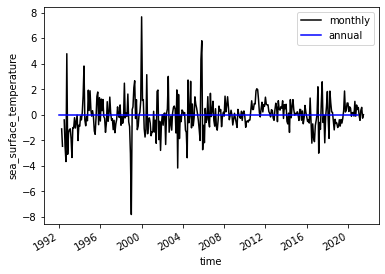

In [10]:
# Map and plot SST anomaly

# Make monthly anomalies
mn_ano = time_average(data,'M',var='sea_surface_temperature',ignore_inc = True).groupby('time.month') - make_clim(data['sea_surface_temperature'],time_res = 'month')[0]
mn_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='monthly',color='black');
# Make yearly anomalies
yr_ano = time_average(data,'Y',var='sea_surface_temperature',ignore_inc = True).groupby('time.year') - make_clim(data['sea_surface_temperature'],time_res = 'year')[0]
yr_ano.stack(space=['lon','lat']).mean(dim='space').plot(label='annual',color='blue');
plt.legend()

In [ ]:
yr_ano[:,1,1]

<font color='blue' size = 6 > <strong> DATA EXTRACTION </strong>  </font>\
\
We can now extract the data in a excel format to enable users to perform further analysis. 
Note that excel spreadsheets have a limited number of rows (2^20), so a dataset that is too large will not save. \
large spatial daily files can take 10-20mins

In [ ]:
d1 = mn_ano[,,slice(100)].to_dataframe()
d2 = yr_ano.to_dataframe()
save_excel([d1,d2],file_name="test1")

In [ ]:
cluster.shutdown()